## GC Rich Regions

1. Defining high GC regions
1. Blastn species output
1. Dinucleotide Counts
1. High GC in Hifiasm
1. Comparing GC% across species
1. Read Coverage - PacBio & Nanopore
1. Read Coverage - Nanopore Only
1. Real Abundance
1. Genes in High GC%
1. Comparing Repeat Regions in different species
1. Primary or Alternate Assembly

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Files:

In [34]:
#blobplot
inblobfn = '/home/jemimah/analysis/v3/blobplot/v3_pd_blastTop10.blobDB.table.txt'
inblobfn_v4 = '/home/jemimah/analysis/hifiasm_assemblies/blobplot/v4_blastTop10_blobplot.blobDB.table.txt'

#blast matches
inblastfn = '/home/jemimah/analysis/v3/blast.v3/Walli.v3.purge_dups.top10hits.blastoutput'

#dinucleotide frequencies, high GC and the rest
di_high_infn = "/home/jemimah/analysis/v3/gc_percent/nucleotide_freq/20200818_di/loose_GC_contigs.calcfreq.compseq"
di_normal_infn = "/home/jemimah/analysis/v3/gc_percent/nucleotide_freq/20200818_di/loose_GC_contigs_complement.calcfreq.compseq"

#same path to the file containing all genomes interested in having their GC calculated
path = "/home/jemimah/analysis/v3/gc_percent/genomes/"
folders = !ls ~/analysis/v3/gc_percent/genomes/

#coverage
infn_v3_1kbCoverage = '/home/jemimah/analysis/v3/coverage/20200604_v3_purged_merged_scripted_1kb/Walli.v3.contigs.purge_dups.1kbNoOverlap.tab'
infn_v3_1kbCoverage_nano = '/home/jemimah/analysis/v3/coverage/20200907_v3_nanopore_only_1kb/Walli.v3.contigs.purge_dups_nanopore_coverage.1kbNoOverlap.tab'
coverage_all = "/home/jemimah/analysis/v3/coverage/20200604_v3_purged_merged_scripted/Walli.v3.contigs.purge_dups_coverage.tab"

#Interproscan results
tsvinfn = "/home/jemimah/analysis/v3/interproscan/20200721_walli_all_protiens/Walli.v3.braker2.aa.both.tsv"

#the section "Comparing repeat region in different species" also contains input links,
# but should be specifically edited

In [4]:
#output for the list fo contigs in high GC
GC_51_outpath = "/home/jemimah/analysis/v3/blobplot/20200810_GC_contigs/" + "GC_51_contigs.list"

### Defining GC Rich

In [5]:
blobheader = "name	length	GC	N	bam0	phylum.t.6%s	phylum.s.7%s	phylum.c.8".split("\t")
blobdf_v3_pd = pd.read_csv(inblobfn, sep='\t', header=None, names = blobheader,  comment = '#')

In [6]:
sizes = blobdf_v3_pd.pivot_table(index=["phylum.t.6%s"], aggfunc='size').to_dict()
new_names = {}
count = 0
others = []
for x in sizes:
    if sizes[x] > 30:
        new_names[x] = x
    else:
        count += sizes[x]
        others += [x]

for x in others:
    new_names[x] = "other"

In [7]:
blobdf_v3_pd["Phylum"] = blobdf_v3_pd["phylum.t.6%s"].map(new_names)

In [8]:
#main peak mean
blobdf_v3_pd[blobdf_v3_pd["GC"] < 0.51]["GC"].mean()
#small peak mean
blobdf_v3_pd[blobdf_v3_pd["GC"] > 0.51]["GC"].mean()
#overall mean
blobdf_v3_pd["GC"].mean()

0.40820297522718907

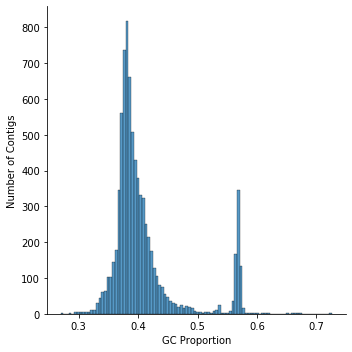

In [9]:
g = sns.displot(blobdf_v3_pd, x="GC", bins=100)
plt.xlabel("GC Proportion")
plt.ylabel("Number of Contigs")

plt.tight_layout()

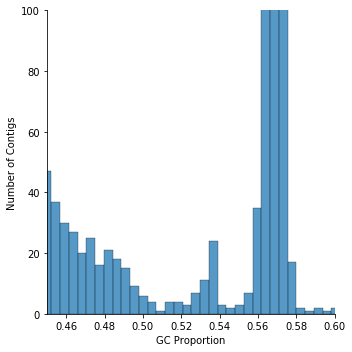

In [10]:
g = sns.displot(blobdf_v3_pd, x="GC", bins=100)
plt.xlabel("GC Proportion")
plt.ylabel("Number of Contigs")
plt.xlim(0.45,0.60)
plt.ylim(0,100)
plt.tight_layout()

(0.2, 0.7)

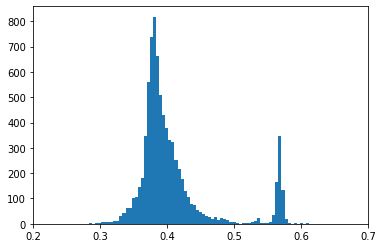

In [11]:
plt.hist(blobdf_v3_pd['GC'], bins= 100)
plt.xlim(0.2,0.7)

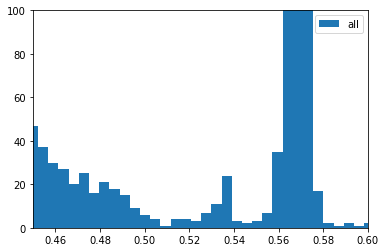

In [12]:
plt.hist(blobdf_v3_pd['GC'], bins= 100,label='all')
plt.xlim(0.45,0.60)
plt.ylim(0,100)
plt.legend()
plt.show()

(0.45, 0.6)

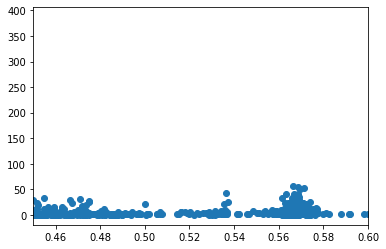

In [13]:
plt.scatter(blobdf_v3_pd['GC'], blobdf_v3_pd['bam0'])
plt.xlim(0.45,0.60)

In [14]:
GC49 = blobdf_v3_pd[blobdf_v3_pd["GC"] > 0.49]
GC50 = blobdf_v3_pd[blobdf_v3_pd["GC"] > 0.5]
GC51 = blobdf_v3_pd[blobdf_v3_pd["GC"] > 0.51]
GC52 = blobdf_v3_pd[blobdf_v3_pd["GC"] > 0.52]
GC53 = blobdf_v3_pd[blobdf_v3_pd["GC"] > 0.53]
print("49  50  51  52  53")
print(len(GC49), len(GC50), len(GC51), len(GC52), len(GC53))
print(" ", len(GC49)- len(GC50), " ", len(GC50)- len(GC51)," ",  len(GC51) - len(GC52)," ",  len(GC52)-len(GC53))

49  50  51  52  53
812 793 784 777 766
  19   9   7   11


So chose 51% as the line

In [15]:
GC_51= list(GC51["name"])

In [16]:
string_GC_51 = "\n".join(GC_51) + "\n"
with open(GC_51_outpath, "w") as f:
    f.write(string_GC_51)

### Blast species output

In [17]:
header = "qseqid staxids bitscore sseqid evalue length pident nident sgi sacc sscinames scomnames sskingdoms sstart send".split()
header = ["qseqid", "staxids", "bitscore", "qseqid2"] + header[4:]
blastdf = pd.read_csv(inblastfn, sep='\t', header=None, names = header)

can check exact matched (eg rDNA) with https://www.ncbi.nlm.nih.gov/nucleotide/[sacc] eg https://www.ncbi.nlm.nih.gov/nucleotide/KP828784

In [18]:
ids_GC_51 = blastdf[blastdf["qseqid"].isin(GC_51)]
diffs = set(list(ids_GC_51["qseqid"].unique())) ^ set(GC_51)
len(GC_51) - len(list(ids_GC_51["qseqid"].unique())) == len(diffs)

True

In [19]:
ids_GC_51["sacc"].unique()

array(['KP828784', 'KP828788', 'KP828795', 'KP828777', 'KP828791',
       'KP828790', 'KP828797', 'KP828787', 'KP828781', 'KP828783',
       'KP828792', 'KP828786', 'KP828793', 'KP828796', 'CP032251',
       'KM117260', 'LR778311', 'LR031586', 'FR694391', 'AM482271',
       'AM444982', 'AM458138', 'AY260162', 'U32066', 'XR_002105493',
       'AF497414', 'U32008', 'LR031873', 'LT669789', 'U32043', 'CP050226',
       'LR778317', 'XR_003634052', 'MK111642', 'AM441499', 'U32051',
       'LR722623', 'XR_002657665', 'CP014157', 'XR_001285859', 'CP025675',
       'XR_003151830', 'KM538955', 'X56866', 'GU172007', 'XR_001681325',
       'M68869', 'U32062', 'XR_004453141', 'XR_004011471', 'LT594797',
       'XR_004453153'], dtype=object)

In [20]:
top_ids_GC_51 = ids_GC_51[::10]
top_ids_list = list(top_ids_GC_51["staxids"])
uniq_top_ids = {i:top_ids_list.count(i) for i in top_ids_list}
n=-1
names = ["Goodenia ovata","Gossypioides kirkii","Goodenia brendannarum","Goodenia tripartita","Goodenia radicans","Lupinus angustifolius","Hordeum vulgare subsp. vulgare"]

GC_51_top_ids_dict = {"Code": [], "Name": [], "Count": []}

for k, v in sorted(uniq_top_ids.items(), key=lambda x: x[1], reverse=True):
    n+=1
    GC_51_top_ids_dict["Code"] = GC_51_top_ids_dict["Code"] + [k]
    GC_51_top_ids_dict["Name"] = GC_51_top_ids_dict["Name"] + [names[n]]
    GC_51_top_ids_dict["Count"] = GC_51_top_ids_dict["Count"] + [v]

GC_51_top_ids_df = pd.DataFrame(GC_51_top_ids_dict)
#the top ids for the GC > 51% results, and how frequent they are
GC_51_top_ids_df

,Code,Name,Count
0,49600,Goodenia ovata,690
1,47615,Gossypioides kirkii,38
2,1690108,Goodenia brendannarum,10
3,1161840,Goodenia tripartita,2
4,49632,Goodenia radicans,2
5,3871,Lupinus angustifolius,2
6,112509,Hordeum vulgare subsp. vulgare,1


https://www.ncbi.nlm.nih.gov/Taxonomy/TaxIdentifier/tax_identifier.cgi  
Goodenia ovata is by far the most common, but the second most is a non-goodineace. These are the same species as the top results in v1.

In [21]:
ids_list = list(ids_GC_51["staxids"])
uniq_ids = {i:ids_list.count(i) for i in ids_list}

GC_51_ids_dict = {"Code": [], "Count": []}

for k, v in sorted(uniq_ids.items(), key=lambda x: x[1], reverse=True):
    GC_51_ids_dict["Code"] = GC_51_ids_dict["Code"] + [k]
    GC_51_ids_dict["Count"] = GC_51_ids_dict["Count"] + [v]

GC_51_ids_df = pd.DataFrame(GC_51_ids_dict)
GC_51_ids_df["Code"] = pd.to_numeric(GC_51_ids_df["Code"])
#all ids for the GC > 51% results results, and how frequent they are
#GC_51_ids_df

In [22]:
#print(GC_51_ids_df["Code"].to_string(index=False))
#paste here: https://www.ncbi.nlm.nih.gov/Taxonomy/TaxIdentifier/tax_identifier.cgi
#save

In [23]:
taxid_report = "/home/jemimah/analysis/v3/gc_percent/taxid_GC51_allIDs_NCBIreport.txt"
taxid_GC51_allIDs_df = pd.read_csv(taxid_report, sep='\t')#, header=None, names = header)
taxid_GC51_allIDs_df = taxid_GC51_allIDs_df[["taxid", "taxname"]].set_index("taxid")
#taxid_GC51_allIDs_df

In [24]:
good_list = ["Scaevola collaris"]
brass_list = ["Raphanus sativus", "Sinapis alba"]
faba_list = ["Wisteria floribunda", "Arachis glandulifera", "Lupinus angustifolius", "Arachis hypogaea"]

conditions = [(taxid_GC51_allIDs_df["taxname"].str.contains("Goodenia")), 
             (taxid_GC51_allIDs_df["taxname"].isin(good_list)),
             (taxid_GC51_allIDs_df["taxname"].str.contains("Goss")),
             (taxid_GC51_allIDs_df["taxname"].str.contains("Brassica")),
             (taxid_GC51_allIDs_df["taxname"].str.contains("Arab")),
             (taxid_GC51_allIDs_df["taxname"].isin(brass_list)),
             (taxid_GC51_allIDs_df["taxname"].str.contains("Pasteurella multocida")),
             (taxid_GC51_allIDs_df["taxname"].isin(faba_list))]
outcomes = ["Goodeniaceae",
            "Goodeniaceae",
            "Malvaceae",
            "Brassicaceae",
            "Brassicaceae",
            "Brassicaceae", 
            "Pasteurellaceae\n(Bacteria)",
            "Fabaceae"] 

In [25]:
taxid_GC51_allIDs_df["Family"] = np.select(conditions, outcomes)
taxid_GC51_allIDs_df = taxid_GC51_allIDs_df.replace("0", "other")
#taxid_GC51_allIDs_df

In [26]:
taxid_GC51_allIDs_dict = taxid_GC51_allIDs_df["taxname"].to_dict()
family_GC51_allIDs_dict = taxid_GC51_allIDs_df["Family"].to_dict()
GC_51_ids_df["Name"] = GC_51_ids_df["Code"].map(taxid_GC51_allIDs_dict)
GC_51_ids_df["Family"] = GC_51_ids_df["Code"].map(family_GC51_allIDs_dict)
#GC_51_ids_df

In [27]:
GC_51_ids_graphable = (GC_51_ids_df.groupby(by=["Family"])["Count"].sum().reset_index()).sort_values("Count", ascending=False).iloc[[0, 2, 3, 4, 5, 1]]

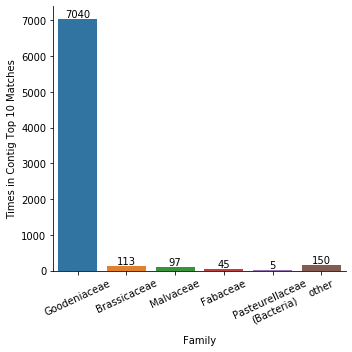

In [28]:
g = sns.catplot(data = GC_51_ids_graphable, x = "Family", y = "Count", kind = "bar")
for i, name in enumerate(GC_51_ids_graphable['Family'].unique()):
    height = int(GC_51_ids_graphable[GC_51_ids_graphable["Family"] == name]["Count"])
    g.ax.text(i-((len(str(height)))/15), height +50, height)
g.set_xticklabels(rotation=25)
plt.ylabel("Times in Contig Top 10 Matches")
plt.tight_layout()
plt.savefig('temp.svg')

### Dinucleotide counts

In [29]:
di_header = ["Dinucleotide", "Count", "Empty" ,"Frequency", "Exp_Frequency","Obs/Exp_Frequency"]
di_high_df = pd.read_csv(di_high_infn, sep = '\t', header = None, names = di_header, skiprows = 26, index_col = None)
di_high_df = di_high_df[di_header[:2] + di_header[3:]]
di_high_df = di_high_df.head((len(di_high_df) -1))
di_high_df["GC%"] = "High"

di_normal_df = pd.read_csv(di_normal_infn, sep = '\t', header = None, names = di_header, skiprows = 26, index_col = None)
di_normal_df = di_normal_df[di_header[:2] + di_header[3:]]
di_normal_df = di_normal_df.head(len(di_high_df))
di_normal_df["GC%"] = "Normal"

di_both_df = di_high_df.append(di_normal_df)
di_both_df["Obs/Exp_Frequency -1"] = di_both_df["Obs/Exp_Frequency"] - 1

Text(15.239201388888887, 0.5, 'Observed Frequency / Expected Frequency')

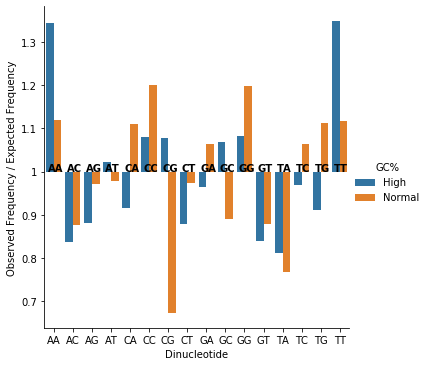

In [30]:
g = sns.catplot(data = di_both_df, x = "Dinucleotide", y = "Obs/Exp_Frequency -1",
                kind = "bar", hue = "GC%")
for i, name in enumerate(di_both_df['Dinucleotide'].unique()):
    g.ax.text(i-0.3, 0 , name, weight = 'bold')

plt.yticks(ticks = [-0.3, -0.2, -0.1, 0 ,0.1, 0.2, 0.3], labels = [0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3])
plt.ylabel("Observed Frequency / Expected Frequency")
#plt.savefig('temp.svg')

### High GC% in Hifiasm

In [31]:
blobheader = "name	length	GC	N	bam0	phylum.t.6%s	phylum.s.7%s	phylum.c.8".split("\t")
blobdf_v4 = pd.read_csv(inblobfn_v4, sep='\t', header=None, names = blobheader,  comment = '#')
blobdf_v4["coverage"] = np.log10(blobdf_v4["bam0"])

/home/jemimah/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


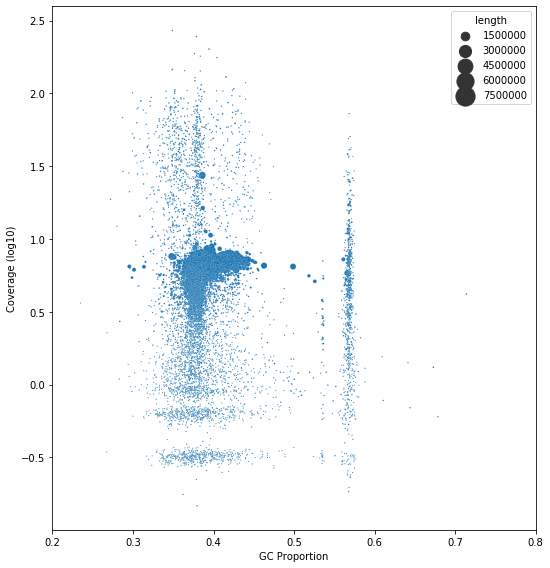

In [32]:
plt.figure(figsize=(7.75,8))
sns.scatterplot(data=blobdf_v4, x="GC", y="coverage", 
                size="length", sizes=(1, 400))#, alpha=.5)
plt.xlim(0.2, 0.8)
plt.ylabel("Coverage (log10)")
plt.xlabel("GC Proportion")
plt.tight_layout()
#plt.savefig('temp.png')

### Comparing GC% across species

In [35]:
nuc_header = "chromosome\tstart\tend\tAT_content\tGC_content\tA_num\tC_num\tG_num\tT_num\tN_num\tother_num\tlength".split("\t")
folders 

['Athaliana_447_TAIR10.fa',
 'Dcarota_388_v2.0.fa',
 'Hannuus_494_r1.0.fa',
 'Lsativa_467_v8.fa',
 'Walli.v3.contigs.purge_dups.fa']

In [37]:
%%bash -s "$path"
cd $1
for x in *.fa ; do samtools faidx ${x} ; awk -v OFS='\t' {'print $1,$2'} ${x}.fai > ${x%%.fa}.gfile ; bedtools makewindows -g ${x%%.fa}.gfile -w 10000 -s 2000 > ${x%%.fa}.bed ; bedtools nuc -fi ${x} -bed ${x%%.fa}.bed > ${x%%.fa}.nuc ; mkdir ${x%%.fa}; mv ${x%%.fa}.* ${x%%.fa}/ ;  done
ls

Athaliana_447_TAIR10
Dcarota_388_v2.0
Hannuus_494_r1.0
Lsativa_467_v8
Walli.v3.contigs.purge_dups


In [41]:
#y = ".10kb"

species = ["A_thaliana", "D_carota", "H_annuus", "L_stavia", "W_ceracea"]
renaming = dict(zip(folders, species))

dfs_renamed = {}
for x in folders:
    nucinfn = path + x[:-3] + "/" + x[:-3] + ".nuc"# + y
    nuc_df = pd.read_csv(nucinfn, sep = '\t', header = None, names = nuc_header, comment = "#")
    name = renaming[x]
    dfs_renamed[name] = nuc_df

In [42]:
GC_df = pd.DataFrame()
for y in species:
    x = y.replace("_",". ")
    GC_df[x] = dfs_renamed[y]["GC_content"]

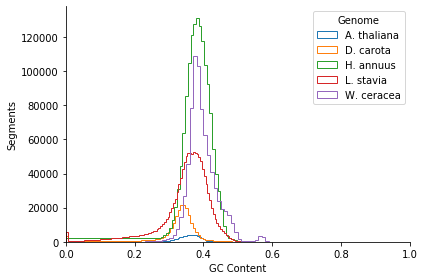

In [43]:
#plt.figure()
ax = plt.subplot(111)
for x in dfs_renamed:
    plt.hist(dfs_renamed[x]["GC_content"], bins= 100, histtype=u'step')#, alpha = 0.2)
    plt.xlim(0,1)
    plt.xlabel("GC%")
    plt.ylabel("Segments")
#    plt.title(x + " " + "GC_content")
plt.legend([x.replace("_", ". ") for x in dfs_renamed.keys()] , title = "Genome")
locs, labels = plt.yticks() 
#plt.yticks(locs, [int(x /1000) for x in locs])
#plt.ylabel("Segments (1000)")
plt.xlabel("GC Content")
#plt.box(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
#plt.savefig('temp.svg')

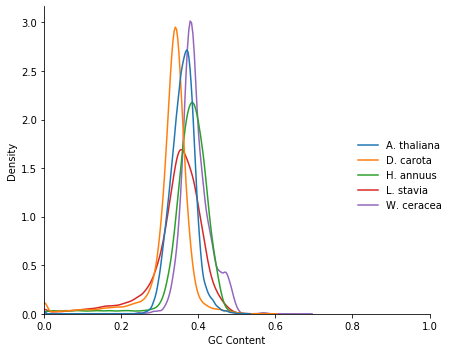

In [44]:
sns.displot(GC_df, kind = "kde")
plt.xlim(0,1)
plt.xlabel("GC Content")
plt.tight_layout()

### Read Coverage - PacBio & Nanopore

In [45]:
header = ['contig', 'start', 'stop', 'cov']
df_v3_1kbcov = pd.read_csv(infn_v3_1kbCoverage, sep='\t', header=None, names=header)
df_v3_1kbcov['size'] = df_v3_1kbcov['stop'] - df_v3_1kbcov['start']
df_v3_1kbcov['norm_cov'] = df_v3_1kbcov['cov']/df_v3_1kbcov['size']

In [46]:
df_v3_1kbcov_GC = df_v3_1kbcov[df_v3_1kbcov["contig"].isin(GC_51)]
df_v3_1kbcov_GC["Assembly"] = "High GC"

<ipython-input-46-a18821198014>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v3_1kbcov_GC["Assembly"] = "High GC"


Text(0.5, 1.0, 'v3: read coverage hisogram of 1kb segments\nwith max coverage 100')

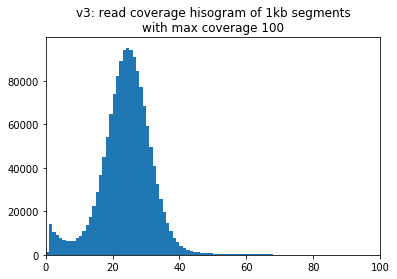

In [47]:
sub_df = df_v3_1kbcov[df_v3_1kbcov['norm_cov'] < 100]
plt.hist(sub_df['norm_cov'], bins= 100)
plt.xlim(0,100)
plt.title("v3: read coverage hisogram of 1kb segments\nwith max coverage 100")

Text(0.5, 1.0, 'v3 High GC%: read coverage hisogram of 1kb segments\nwith max coverage 100')

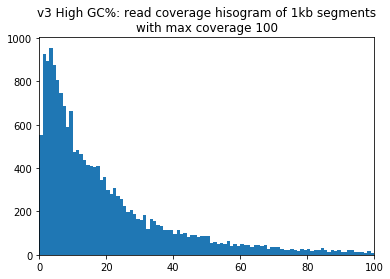

In [48]:
sub_df = df_v3_1kbcov_GC[df_v3_1kbcov_GC['norm_cov'] < 100]
plt.hist(sub_df['norm_cov'], bins= 100)
plt.xlim(0,100)
plt.title("v3 High GC%: read coverage hisogram of 1kb segments\nwith max coverage 100")

Text(0.5, 1.0, 'v3 read coverage hisogram of 1kb segments\noverlay is without high GC%')

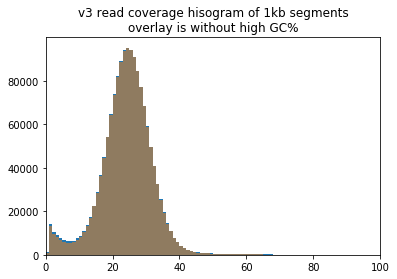

In [49]:
sub_df = df_v3_1kbcov[df_v3_1kbcov['norm_cov'] < 100]
plt.hist(sub_df['norm_cov'], bins= 100)
df_v3_1kbcov_notGC = df_v3_1kbcov[~df_v3_1kbcov["contig"].isin(GC_51)]
sub_df = df_v3_1kbcov_notGC[df_v3_1kbcov_notGC['norm_cov'] < 100]
plt.hist(sub_df['norm_cov'], bins= 100, alpha = 0.5)
plt.xlim(0,100)
plt.title("v3 read coverage hisogram of 1kb segments\noverlay is without high GC%")

In [50]:
df_v3_1kbcov_notGC = df_v3_1kbcov[~df_v3_1kbcov["contig"].isin(GC_51)]
df_v3_1kbcov_notGC["Assembly"] = "Doesn't include High GC"
df_v3_1kbcov["Assembly"] = "Does include high GC"
GC_coverage = df_v3_1kbcov[df_v3_1kbcov['norm_cov'] < 100]
GC_coverage = GC_coverage.append(df_v3_1kbcov_notGC[df_v3_1kbcov_notGC['norm_cov'] < 100])

<ipython-input-50-32a47efb742d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v3_1kbcov_notGC["Assembly"] = "Doesn't include High GC"


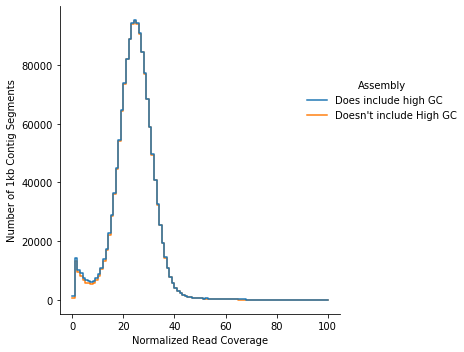

In [51]:
g = sns.displot(GC_coverage, x="norm_cov", hue="Assembly", bins=100, 
            element="step", fill =False)#, legend=False)
plt.xlabel("Normalized Read Coverage")
plt.ylabel("Number of 1kb Contig Segments")
g.legend.set_bbox_to_anchor((.9, .7))

In [52]:
GC_coverage = df_v3_1kbcov_GC.append(df_v3_1kbcov_notGC)
GC_coverage = GC_coverage[GC_coverage['norm_cov'] < 100]

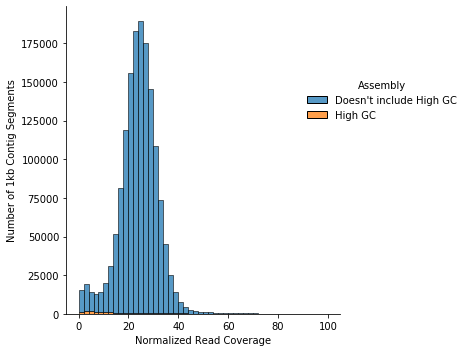

In [53]:
g = sns.displot(GC_coverage.sort_values("Assembly"), x="norm_cov", hue="Assembly",
                bins=50 , multiple="stack")#, element="step", fill =False)#, legend=False)
plt.xlabel("Normalized Read Coverage")
plt.ylabel("Number of 1kb Contig Segments")
g.legend.set_bbox_to_anchor((.9, .7))
#plt.savefig('temp.svg')

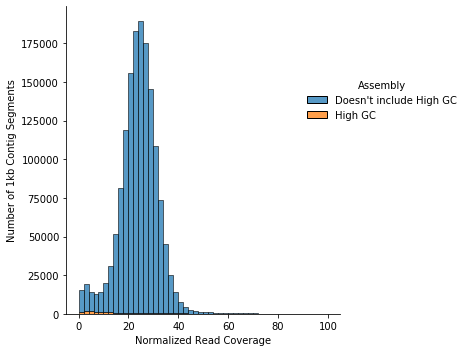

In [54]:
g = sns.displot(GC_coverage.sort_values("Assembly"), x="norm_cov", hue="Assembly",
                bins=50 , multiple="stack")#, element="step", fill =False)#, legend=False)
plt.xlabel("Normalized Read Coverage")
plt.ylabel("Number of 1kb Contig Segments")
g.legend.set_bbox_to_anchor((.9, .7))
#plt.savefig('temp.svg')

### Read Coverage - Nanopore Only

In [55]:
header = ['contig', 'start', 'stop', 'cov']
df_v3_1kbcov_nano = pd.read_csv(infn_v3_1kbCoverage_nano, sep='\t', header=None, names=header)
df_v3_1kbcov_nano['size'] = df_v3_1kbcov_nano['stop'] - df_v3_1kbcov_nano['start']
df_v3_1kbcov_nano['norm_cov'] = df_v3_1kbcov_nano['cov']/df_v3_1kbcov_nano['size']

In [56]:
df_v3_1kbcov_nano_GC = df_v3_1kbcov_nano[df_v3_1kbcov_nano["contig"].isin(GC_51)]
#df_v3_1kbcov_nano_GC

Text(0.5, 1.0, 'v3: read coverage hisogram of 1kb segments\nwith max coverage 50')

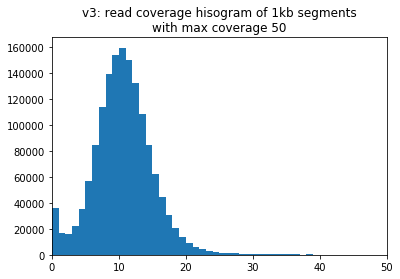

In [57]:
sub_df = df_v3_1kbcov_nano[df_v3_1kbcov_nano['norm_cov'] < 50]
plt.hist(sub_df['norm_cov'], bins= 50)
plt.xlim(0,50)
plt.title("v3: read coverage hisogram of 1kb segments\nwith max coverage 50")

Text(0.5, 1.0, 'v3 High GC%: read coverage hisogram of 1kb segments\nwith max coverage 50')

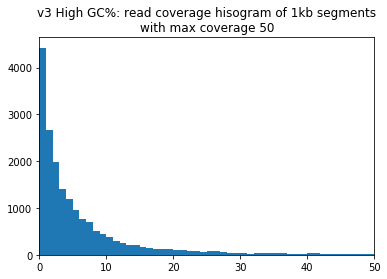

In [58]:
sub_df = df_v3_1kbcov_nano_GC[df_v3_1kbcov_nano_GC['norm_cov'] < 50]
plt.hist(sub_df['norm_cov'], bins= 50)
plt.xlim(0,50)
plt.title("v3 High GC%: read coverage hisogram of 1kb segments\nwith max coverage 50")

Text(-2.450000000000003, 0.5, 'Number of 1kb Contig Segments')

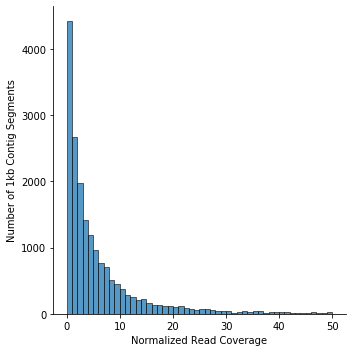

In [59]:
g = sns.displot(sub_df, x="norm_cov", bins=50)#, element="step", fill =False)#, legend=False)
plt.xlabel("Normalized Read Coverage")
plt.ylabel("Number of 1kb Contig Segments")

In [60]:
df_v3_1kbcov_nano_noGC = df_v3_1kbcov_nano[~df_v3_1kbcov_nano["contig"].isin(GC_51)]
df_v3_1kbcov_nano_noGC["Assembly"] = "Doesn't include High GC"
df_v3_1kbcov_nano_GC["Assembly"] = "High GC"
GC_coverage_nano = df_v3_1kbcov_nano_GC.append(df_v3_1kbcov_nano_noGC)

<ipython-input-60-9b3c7fdf2867>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v3_1kbcov_nano_noGC["Assembly"] = "Doesn't include High GC"
<ipython-input-60-9b3c7fdf2867>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v3_1kbcov_nano_GC["Assembly"] = "High GC"


In [61]:
GC_coverage_nano = GC_coverage_nano[GC_coverage_nano["norm_cov"] < 50]

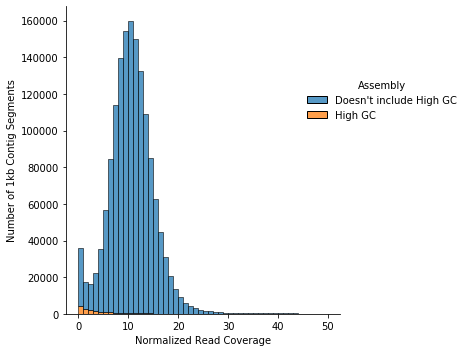

In [62]:
g = sns.displot(GC_coverage_nano.sort_values("Assembly"), x="norm_cov", hue="Assembly",
                bins=50 , multiple="stack")#, element="step", fill =False)#, legend=False)
plt.xlabel("Normalized Read Coverage")
plt.ylabel("Number of 1kb Contig Segments")
g.legend.set_bbox_to_anchor((.9, .7))
#plt.savefig('temp.svg')

In [63]:
GC_coverage_nano["Reads"] = "B. Nanopore Only"
GC_coverage["Reads"] = "A. PacBio and Nanopore"
GC_coverage_nano_and_both = GC_coverage.append(GC_coverage_nano)
GC_coverage_nano_and_both["Normalized Read Coverage"] = GC_coverage_nano_and_both["norm_cov"]

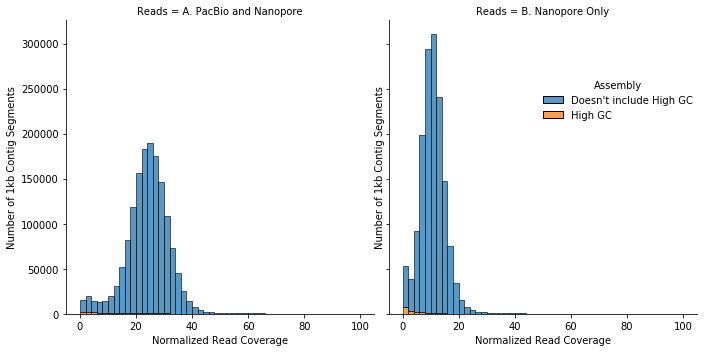

In [64]:
g = sns.displot(GC_coverage_nano_and_both.sort_values("Assembly"),
                x="Normalized Read Coverage", hue="Assembly", col = "Reads",
                bins=50 , multiple="stack") 
plt.xlabel("Normalized Read Coverage")
g.legend.set_bbox_to_anchor((.8, .7))
for ax in g.axes.flat:
    ax.set_ylabel("Number of 1kb Contig Segments")


### Real Abundance

**full contig coverage**

In [65]:
header = ['contig', 'start', 'stop', 'cov']
coverage_all = pd.read_csv(coverage_all, sep='\t', header=None, names=header)
coverage_all['norm_cov'] = coverage_all['cov']/coverage_all['stop']
coverage_high = coverage_all[coverage_all["contig"].isin(GC_51)]
coverage_nothigh = coverage_all[~coverage_all["contig"].isin(GC_51)]

In [66]:
coverage_all_mean = coverage_all["norm_cov"].mean()
coverage_all_mean

24.54450735684293

In [67]:
coverage_high["norm_cov"].mean()

21.5148741964282

In [68]:
coverage_high["true_length"] = ((coverage_high["stop"]*coverage_high["norm_cov"])/coverage_all_mean)

<ipython-input-68-3f991f29c1d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coverage_high["true_length"] = ((coverage_high["stop"]*coverage_high["norm_cov"])/coverage_all_mean)


In [69]:
print(coverage_high["true_length"].sum())
print(coverage_high["stop"].sum())

20513137.244110543
18637078


Text(0.5, 1.0, 'coverage_high, full contigs, length vs coverage')

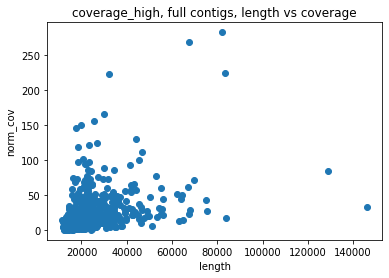

In [70]:
plt.scatter(coverage_high['stop'], coverage_high['norm_cov'])
#plt.xlim(0, 8000000)
plt.xlabel("length")
plt.ylabel("norm_cov")
plt.title("coverage_high, full contigs, length vs coverage")

**1kb regions coverage**

In [71]:
coverage_all_1kb_mean = df_v3_1kbcov["norm_cov"].mean()
coverage_all_1kb_mean

26.220653545336365

In [72]:
df_v3_1kbcov

,contig,start,stop,cov,size,norm_cov,Assembly
0,tig00000001,0,1000,6476,1000,6.47600,Does include high GC
1,tig00000001,1000,2000,10587,1000,10.58700,Does include high GC
2,tig00000001,2000,3000,12302,1000,12.30200,Does include high GC
3,tig00000001,3000,4000,15327,1000,15.32700,Does include high GC
4,tig00000001,4000,5000,16835,1000,16.83500,Does include high GC
...,...,...,...,...,...,...,...
1527651,hap_tig00120901,9000,10000,1000,1000,1.00000,Does include high GC
1527652,hap_tig00120901,10000,11000,1000,1000,1.00000,Does include high GC
1527653,hap_tig00120901,11000,12000,1000,1000,1.00000,Does include high GC
1527654,hap_tig00120901,12000,13000,1644,1000,1.64400,Does include high GC


In [73]:
coverage_high_1kb = df_v3_1kbcov[df_v3_1kbcov["contig"].isin(GC_51)]
coverage_high_1kb["true_length"] = ((coverage_high_1kb["size"]*coverage_high_1kb["norm_cov"])/coverage_all_1kb_mean)

<ipython-input-73-e484f09d02f5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coverage_high_1kb["true_length"] = ((coverage_high_1kb["size"]*coverage_high_1kb["norm_cov"])/coverage_all_1kb_mean)


In [74]:
print("\t\t\t1kb\tfull contigs")
print("high GC% 'true' length:", int(coverage_high_1kb["true_length"].sum()), int(coverage_high["true_length"].sum()))
print("high GC% length summed:", coverage_high_1kb["size"].sum(), coverage_high["stop"].sum())

			1kb	full contigs
high GC% 'true' length: 19201842 20513137
high GC% length summed: 18637078 18637078


So "true lengths" are in fact bigger than length by sum, for both 1kb and contigs. 1kb and contigs differ in "true length", probably because for some long contigs there are high coverage and low coverage regions, and the whole contigs is benefitting from those high coverage regions.   

It looks like extreams are higher in 1kb regions - some regions with 0 coverage and other with 400*

Text(0.5, 1.0, 'high GC%, whole contigs')

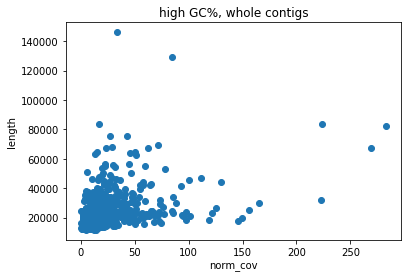

In [75]:
plt.scatter(coverage_high['norm_cov'], coverage_high['stop'])
#plt.xlim(0, 120000)
plt.ylabel("length")
plt.xlabel("norm_cov")
plt.title("high GC%, whole contigs")

Should I investiage these few high cov contigs more?

In [76]:
print("\t\t\t1kb\tfull contigs")
print("high GC% 'true' length:", int(coverage_high_1kb["true_length"].sum()), int(coverage_high["true_length"].sum()))
print("high GC% true, cov<200:", int(coverage_high_1kb[coverage_high_1kb["norm_cov"] <200 ]["true_length"].sum()), int(coverage_high[coverage_high["norm_cov"] < 200]["true_length"].sum()))
print("high GC% true, low cov:", int(coverage_high_1kb[coverage_high_1kb["norm_cov"] <300 ]["true_length"].sum()), int(coverage_high[coverage_high["norm_cov"] < 200]["true_length"].sum()))
print("high GC% length summed:", coverage_high_1kb["size"].sum(), coverage_high["stop"].sum())

			1kb	full contigs
high GC% 'true' length: 19201842 20513137
high GC% true, cov<200: 16402718 17770998
high GC% true, low cov: 17557544 17770998
high GC% length summed: 18637078 18637078


In [77]:
coverage_high_1kb[coverage_high_1kb["norm_cov"] > 300]["contig"].unique()

array(['tig00018789', 'tig00019614', 'tig00019637', 'hap_tig00018863',
       'hap_tig00027935'], dtype=object)

So if we remove the 4 or 5 highest coverage contigs then "true length" does become less than contig length summed, though not by a degree of magnitude. As ben points out: Given that "true length" of the GC% on average matches the sum of the contig lengths it overall does represent the real sequence space. The variation is probably a challenge of the assembler trying to handle lots of repeats

### Genes in high GC%

In [78]:
tsv_df = pd.read_csv(tsvinfn, sep = '\t')

In [79]:
high_gc = tsv_df[tsv_df['Contig_short'].isin(GC_51)]

In [80]:
print(len(tsv_df))
print(len(high_gc))
print(len(high_gc["SequenceMD5"].unique()))

710685
9956
904


In [81]:
high_gc_unique = high_gc.drop_duplicates("SequenceMD5")
high_gc_unique['MD5_freq'] = high_gc_unique['SequenceMD5'].map(((high_gc.groupby('SequenceMD5').size()).to_dict()))

<ipython-input-81-bb93a0fbd2df>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_gc_unique['MD5_freq'] = high_gc_unique['SequenceMD5'].map(((high_gc.groupby('SequenceMD5').size()).to_dict()))


In [82]:
high_gc_unique_sort = high_gc_unique.sort_values("MD5_freq", ascending=False)
#high_gc_unique_sort[:12]

It takes 12 rows to get to something with a signature description that is neither - nor "consensus disorder prediction"

In [83]:
print((high_gc_unique_sort[:11]["MD5_freq"].sum())/len(high_gc))
print(high_gc_unique_sort[:2]["MD5_freq"].sum()/len(high_gc))

0.49949779027721974
0.3058457211731619


That means approx half of all "genes" apparently in this region are unidentified, and the top two (completely unidentified "genes") alone account for 30%.

This becomes even less when we remove duplicate signature accessions

In [84]:
dict_ac = {}
for x in high_gc_unique_sort["Signature_accession"].unique():
    dict_ac[x] = high_gc_unique_sort[high_gc_unique_sort["Signature_accession"]== x]['MD5_freq'].sum()
len(dict_ac) ==len(high_gc_unique_sort["Signature_accession"].unique())

True

In [85]:
high_gc_unique_ac = high_gc_unique_sort.drop_duplicates("Signature_accession")
high_gc_unique_ac['ac_freq'] = (high_gc_unique_ac['Signature_accession'].map(dict_ac))
high_gc_unique_ac_sort = high_gc_unique_ac.sort_values("ac_freq", ascending = False)
#high_gc_unique_ac_sort[:10]

<ipython-input-85-a989d13b8fb0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_gc_unique_ac['ac_freq'] = (high_gc_unique_ac['Signature_accession'].map(dict_ac))


In [86]:
print(len(high_gc[high_gc["Signature_description"] == "consensus disorder prediction"])/len(high_gc))

0.2939935717155484


In [87]:
print((high_gc_unique_ac_sort[:10]["ac_freq"].sum())/len(high_gc))
print(high_gc_unique_ac_sort[:3]["ac_freq"].sum()/len(high_gc))

0.8152872639614303
0.6785857774206508


It looks like having _some_ large frequencies are happening outside of this region, but not as much as inside it.

In [88]:
tsv_df_contigs_unique = tsv_df .drop_duplicates("SequenceMD5")
tsv_df_contigs_unique['MD5_freq'] = tsv_df_contigs_unique['SequenceMD5'].map(((tsv_df.groupby('SequenceMD5').size()).to_dict()))
#tsv_df_contigs_unique.sort_values("MD5_freq", ascending=False).head(5)

<ipython-input-88-cb6846f68a63>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsv_df_contigs_unique['MD5_freq'] = tsv_df_contigs_unique['SequenceMD5'].map(((tsv_df.groupby('SequenceMD5').size()).to_dict()))


### Comparing repeat region in different species

Files are needed here too

In [89]:
full_dict = {}
full_dict["W_ceracea_both"] = !awk '{s+=$2}END{print s}' /home/jemimah/analysis/v3/gc_percent/genomes/Walli.v3.contigs.purge_dups/Walli.v3.contigs.purge_dups.fa.fai
full_dict["W_ceracea"] = !awk '{s+=$2}END{print s}' /home/jemimah/analysis/v3/purge_dups_20200528/Walli.v3.purged.fa.fai
full_dict["H_annuus"] = !awk '{s+=$2}END{print s}' ~/analysis/v3/gc_percent/genomes/Hannuus_494_r1.0/Hannuus_494_r1.0.fa.fai
full_dict["Lsativa_467_v8"] = !awk '{s+=$2}END{print s}' ~/analysis/v3/gc_percent/genomes/Lsativa_467_v8/Lsativa_467_v8.fa.fai
full_dict["Dcarota_388_v2"] = !awk '{s+=$2}END{print s}' ~/analysis/v3/gc_percent/genomes/Dcarota_388_v2.0/Dcarota_388_v2.0.fa.fai
full_dict["Athaliana_447_TAIR10"] = !awk '{s+=$2}END{print s}' ~/analysis/v3/gc_percent/genomes/Athaliana_447_TAIR10/Athaliana_447_TAIR10.fa.fai
for keys in full_dict:
    full_dict[keys] = [int(full_dict[keys][0]) ]

In [90]:
phytosome_files = !ls ~/analysis/v3/blast.v3/20200917_phytosome_genomes/*.bed
other_files = !ls ~/analysis/v3/blast.v3/20200915_H_annuus/*.blastn.bed
files = other_files + phytosome_files

In [91]:
for file in files:
    _df = pd.read_csv(file, sep='\t', header=None, names=header)
    _df['length'] = _df['stop'] - _df['start']
    _df_total = _df.length.sum()
    name = (file.split("/")[-1]).split(".")[0]
    _dict = {name: full_dict[name] + [ _df_total]}
    full_dict.update(_dict)

In [92]:
matches = pd.DataFrame.from_dict(full_dict, orient='index', columns=["total_bp", "whole_bp", "short_bp"])
matches["short_%"] = matches["short_bp"] / matches["total_bp"] *100
matches["whole_%"] = matches["whole_bp"] / matches["total_bp"] *100
matches["Proportion of Assembly (%)"] = matches["whole_bp"] / matches["total_bp"] *100
matches["Length (Mb)"] = matches["whole_bp"] /1000000
matches["Genome (haploid)"] = ["W. ceracea (complete)", "W. ceracea",
                     "H. annuus", "L. sativa", "D. carota", "A. thaliana"]
matches[["Genome (haploid)", "whole_bp", "whole_%", "short_bp", "short_%", "total_bp"]]

,Genome (haploid),whole_bp,whole_%,short_bp,short_%,total_bp
W_ceracea_both,W. ceracea (complete),12891157,0.846075,8916004,0.585177,1523642328
W_ceracea,W. ceracea,8571041,1.067424,5486208,0.683244,802964885
H_annuus,H. annuus,1071968,0.035402,1071515,0.035387,3027963057
Lsativa_467_v8,L. sativa,16283,0.000679,16280,0.000678,2399509484
Dcarota_388_v2,D. carota,42298,0.010035,42298,0.010035,421502825
Athaliana_447_TAIR10,A. thaliana,11434,0.009555,11434,0.009555,119667750


The sequence is present in them, but far less. (table details: "short" refers to a 6000bp region I pulled from one of the high GC contigs that had a lot of blast matches, while "whole" refers to that whole contig. bp is number of base pairs, while % is % of total genome length. The high GC% at the bottom is just the total value of the high GC% contigs as a % of total bp). All walli results were done with the full assembly (primary and alternate) as has been the case with all the high GC% stuff I have done, which could explain some of the difference in result between Walli and Sunflower, but it is interesting the others are so much less.

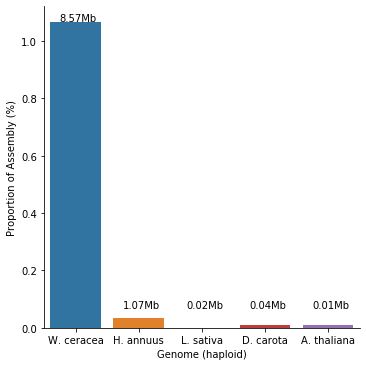

In [93]:
g = sns.catplot(data = matches[1:], x="Genome (haploid)", y= "Proportion of Assembly (%)", kind = "bar")
for i, name in enumerate(matches[1:]["Genome (haploid)"].unique()):
    height = int(matches[matches["Genome (haploid)"] == name]["Proportion of Assembly (%)"])
    text = round(float(matches[matches["Genome (haploid)"] == name]["Length (Mb)"]),2)                                                     
    g.ax.text(i- 0.25, height + 0.07, str(text) + "Mb")
#g.savefig('temp.svg')

But the total GC region is still bigger than the region of matches

In [94]:
coverage_high.stop.sum()/(full_dict["W_ceracea"][0]) *100

2.3210327559965465

### GC rich regions: Primary or Alternate?

In [95]:
GC_51_alt = [k for k in GC_51 if 'hap' in k]
GC_51_pri = [k for k in GC_51 if not 'hap' in k]

In [96]:
print("Of the", len(GC_51), "contigs in loose high GC", len(GC_51_pri), "(" + str(int(len(GC_51_pri)/len(GC_51)*100)) +
      "%) are in the primary assembly and", len(GC_51_alt), "(" + str(int(len(GC_51_alt)/len(GC_51)*100)) +
      "%) are in the alternate assembly.")

Of the 784 contigs in loose high GC 462 (58%) are in the primary assembly and 322 (41%) are in the alternate assembly.
